### Library

In [2]:
import os
import random
import pandas as pd
import seaborn as sns
from pycocotools.coco import COCO

### path

In [4]:
data_dir = '/opt/ml/detection/dataset'
train_json_dir = '/opt/ml/detection/dataset/train.json'

In [9]:
train_coco = COCO(train_json_dir)
images = train_coco.dataset['images']
categories = train_coco.dataset['categories']
annotations = train_coco.dataset['annotations']

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


### class 별 bounding box 개수

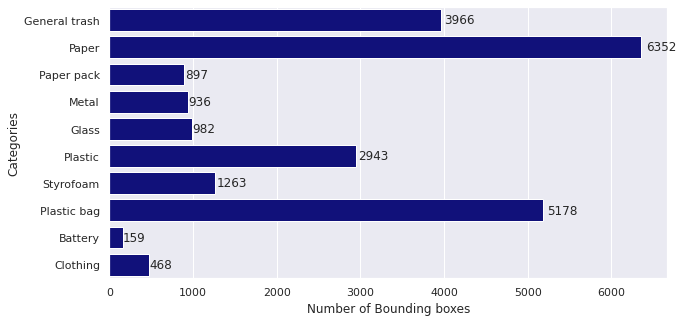

In [23]:
cate_bbox = [] # 카테고리별 bbox 개수 담는 리스트
cate_name = [] # 카테고리별 이름 담는 리스트
for idx in range(10):
    # a는 카테고리별 annotation의 id 리스트
    a = train_coco.getAnnIds(catIds=idx)
    # 카테고리별 bbox 개수는 len(a)
    cate_bbox.append(len(a))
    # 카테고리별 이름 저장
    cate_name.append(categories[idx]['name'])

# 카테고리와 bbox 개수로 DataFrame 생성
df_cate = pd.DataFrame({'Categories':cate_name, 'Number of Bounding boxes' :cate_bbox})

# barplot
sns.set(rc = {'figure.figsize':(10, 5)})
bat_plot = sns.barplot(x="Number of Bounding boxes", y="Categories", data=df_cate, label="Total", color="darkblue")

# 막대그래프의 값 표시
for i, p in enumerate(bat_plot.patches):
    x, y, width, height = p.get_bbox().bounds
    bat_plot.text(width*1.01, y+height/2, df_cate['Number of Bounding boxes'][i], va='center')

### 이미지 shape & Bounding box 개수 별 이미지의 수

총 이미지 개수 : 4883
이미지 shape : {'width': {1024: 4883}, 'height': {1024: 4883}}


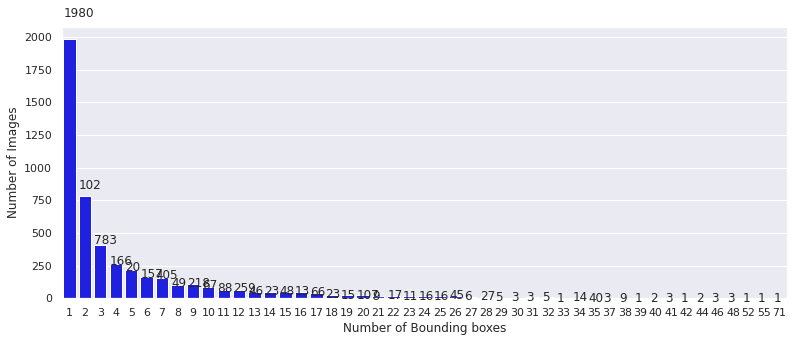

In [41]:
from collections import Counter

image_shape = {'width' : {}, 'height' : {}} # image shape 별 count
bbox_image = [] # bbox 개수 별 이미지의 수 담는 리스트
for id in range(len(images)):
    # b는 이미지별 정보 로드
    b = train_coco.loadImgs(id)[0]
    # 이미지의 width, height 정보 image_shape에 담기
    if b['width'] not in image_shape['width'].keys():
        image_shape['width'][b['width']] = 1
    else:
        image_shape['width'][b['width']] += 1
    if b['height'] not in image_shape['height'].keys():
        image_shape['height'][b['height']] = 1
    else:
        image_shape['height'][b['height']] += 1
    # anno는 이미지 id에 따른 annotation id 담은 리스트
    anno = train_coco.getAnnIds(imgIds=id)
    # anno개수가 이미지 당 가지고 있는 bbox 개수
    bbox_image.append(len(anno))

print('총 이미지 개수 :' , len(images))
print('이미지 shape :', image_shape)

# bbox_image의 값을 x라 하고 그 개수는 y
x = Counter(bbox_image).keys()
y = Counter(bbox_image).values()
# bbox 개수를 x로 이미지 개수를 y로 하는 Dataframe 생성
df_bbox = pd.DataFrame({'Number of Bounding boxes' : x, 'Number of Images' : y })

# barplot
sns.set(rc = {'figure.figsize':(13, 5)})
bat_plot_2 = sns.barplot(x="Number of Bounding boxes", y="Number of Images", data=df_bbox, label="Total", color="blue")
# 막대 값 표시
for i, p in enumerate(bat_plot_2.patches):
    x, y, width, height = p.get_bbox().bounds
    bat_plot_2.text(x, y+height*1.1, df_bbox['Number of Images'][i], va='center')

### 시각화 

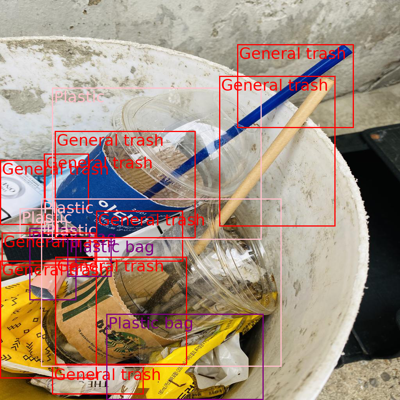

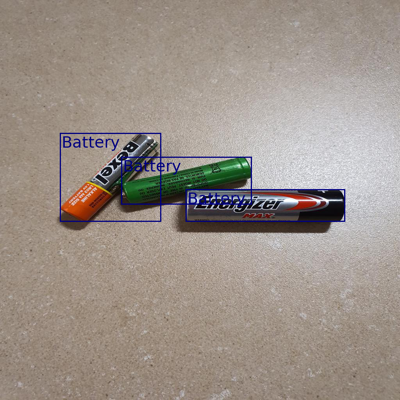

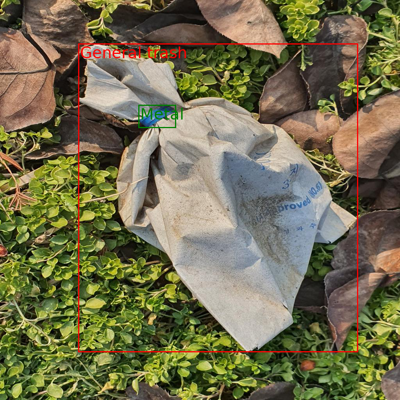

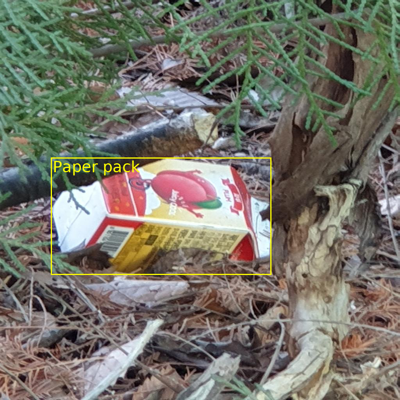

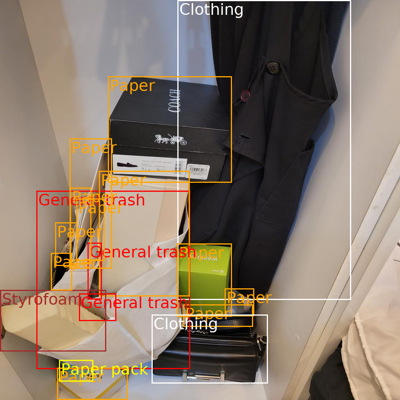

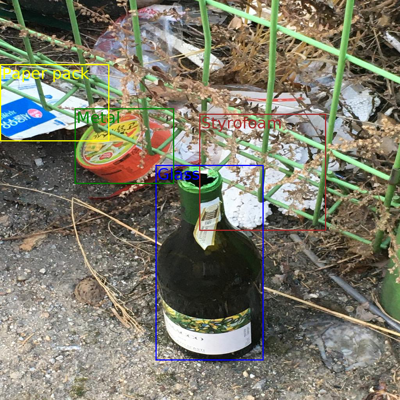

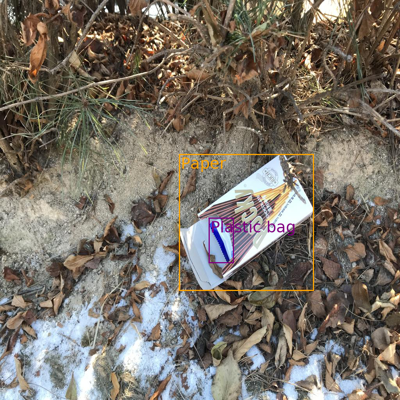

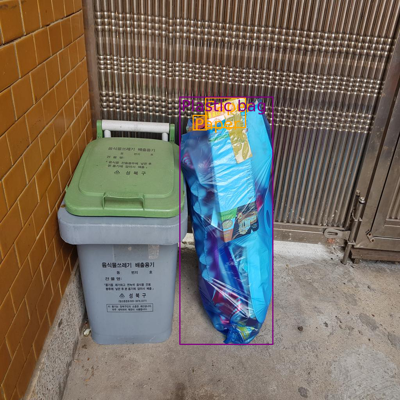

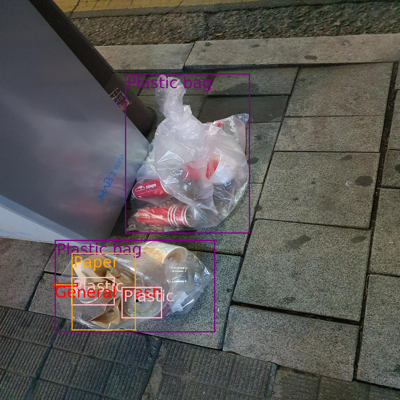

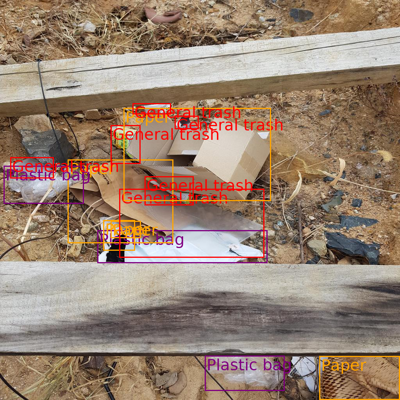

In [53]:
from PIL import Image, ImageDraw, ImageFont
# 카테고리 당 색깔 설정
cate_color = {0: 'red', 1:'orange', 2:'yellow', 3:'green', 4:'blue', 5:'pink', 6:'brown', 7:'purple', 8:'navy', 9:'white'}
# bbox에 표시할 폰트
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 40)

# random하게 10개 이미지 뽑아내서 시각화
for _ in range(10):
    idx = random.randint(0, len(images)) # 뽑아내고 싶은 이미지 id
    image_info = train_coco.loadImgs(idx)[0]
    img = Image.open(os.path.join(data_dir, image_info['file_name']))
    draw = ImageDraw.Draw(img)
    # 이미지 id 당 가지고 있는 bbox 그리기
    for anno_id in train_coco.getAnnIds(imgIds=idx):
        # annotation id에 따른 정보 로드
        anno_info = train_coco.loadAnns(anno_id)[0]
        # x는 xmin, y는 ymin, w는 너비, h는 높이
        [x, y, w, h] = anno_info['bbox']
        # rectangle의 인자는 (xmin, ymin, xmax, ymax), outline은 color 지정
        draw.rectangle((x, y, x+w, y+h), outline=cate_color[anno_info['category_id']], width = 3)
        # text 위치
        text_pos = (x+5, y)
        # cate_name[anno_info['category_id']]이 원하는 카테고리 이름, fill은 color 지정
        draw.text(text_pos, cate_name[anno_info['category_id']], fill=cate_color[anno_info['category_id']], font=font)
    
    # 이미지 사이즈 줄여서 시각화
    img_small = img.resize((400, 400))
    img_small.show()